### Nonlinear Option Pricing, Master 2 Probabilités et Finance, Sorbonne Université and École polytechnique
# Homework I (optional) - Nathan FLEURY

### Due Date: 11:55 PM Thursday, January 22, 2026
You should turn in the notebook on the Moodle course website.

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
plt.rc('figure', figsize=(6, 5.5))
plt.rc('axes', grid=True, xmargin=0, ymargin=0, autolimit_mode='round_numbers')

# 1. Conditional Expection and Least Square Regression

Let $X$ and $Y$ be two random variables. The conditional expectation $\mathbb{E}\left[Y|X\right]$ is a function $f^{\ast}$ of $X$ that best approximates $Y$ in the least square sense, i.e.,

$$\mathbb{E}\left[Y|X\right]=f^{\ast}(X)\quad\text{and}\quad\mathbb{E}\left[\left|Y-f^{\ast}(X)\right|^2\right]\leq\mathbb{E}\left[\left|Y-f(X)\right|^2\right]\text{ for any function }f\text{ of }X$$

Let us define the random variables $X$ and $Y$ by
$$
g(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = g(X) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, 1/16)$ is independent of $X$.

Note that $\mathbb{E}\left[\left.Y\right|X\right] = \mathbb{E}\left[\left.g(X)+\varepsilon\right|X\right] = g(X)+\mathbb{E}\left[\left.\varepsilon\right|X\right] = g(X)$.

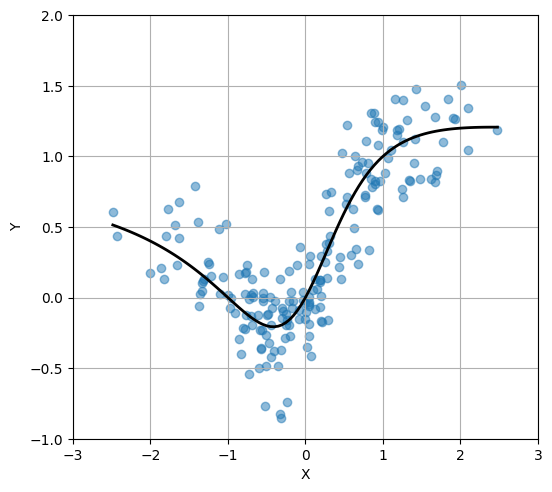

In [2]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.

def g(x):
    return x*(1+x)/(1+x**2)

# Generate data from the model Y = g(X) + N(0,sigma^2)
n = 200
sigma = 0.25 # variance = sigma^2 = 1/16
X = np.random.randn(n)
Y = g(X) + sigma * np.random.randn(n)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
x = np.linspace(X.min(), X.max(), 101)

# Plot the theoretical conditional expectation E[Y|X] = g(X)
ax.plot(x, g(x), 'k', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

## Parametric regression

The conditional expection $\mathbb{E}\left[\left.Y\right|X\right]$ is approximated by a linear combination of a set of given <em>basis</em> functions $\{f_i(X)\}_{0\leq i\leq n}$, i.e.,

$$\mathbb{E}\left[Y|X\right]\approx \beta_0^*f_0(X)+\cdots+\beta_n^*f_n(X)$$

where 

$$\mathbb{E}\left[\left(Y-\beta_0^*f_0(X)-\cdots-\beta_n^*f_n(X)\right)^2\right] = \min_{\beta_1,\ldots,\beta_n}\mathbb{E}\left[\left(Y-\beta_0f_0(X)-\cdots-\beta_nf_n(X)\right)^2\right]$$

Given $N$ observations $\left((x_1,y_1),\ldots,(x_N, y_N)\right)$ of $X$ and $Y$, one finds the optimal parameters $\beta_i$ by solving the least square problem $\min_\beta\|A\beta-y\|_2$, where

$$A=\begin{bmatrix}f_0(x_1) & \cdots & f_n(x_1)\\ \vdots & \ddots & \vdots \\ f_0(x_N) & \cdots & f_n(x_N)\end{bmatrix}\quad
\text{and}\quad y=\begin{bmatrix}y_1\\ \vdots \\ y_N\end{bmatrix}$$

The numpy routine <strong>numpy.linalg.lstsq</strong> can be used to solve such linear least square problems.

### Polynomials

The basis functions are taken to be power functions $f_i(X)=X^{i}$, that is $\mathbb{E}\left[Y|X\right]$ is a polynomial of $X$. The numpy routine <strong>numpy.polyfit</strong> is a convenient way to obtain the least square polynomial fit.

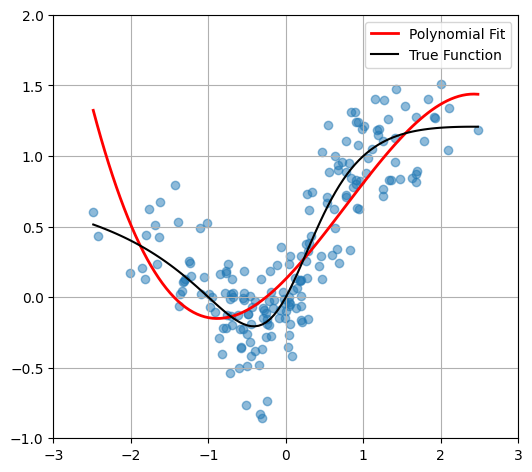

In [3]:
# Fit a polynomial of degree 3 to the sample points (X, Y)
p = np.polyfit(X, Y, deg=3)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, np.polyval(p, x), 'r', lw=2, label='Polynomial Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
plt.show()

### Piecewise Linear Regression

In [4]:
# Define piecewise linear basis functions and fitting function
def pwlin_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs

# Fit piecewise linear function to data
def pwlin_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlin_basis(xknots)
    A = np.column_stack([f(xdata) for f in fs])
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

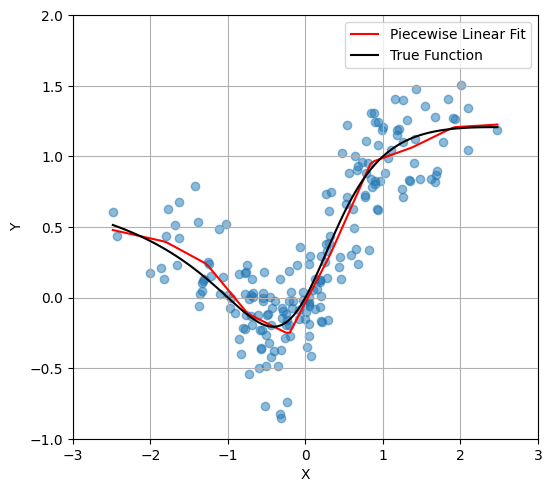

In [5]:
xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 8)
ps, fs = pwlin_fit(X, Y, xknots)
fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), 'r', label='Piecewise Linear Fit')
ax.plot(x, g(x), 'k', label='True Function')
ax.legend(loc=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

## Nonparametric regression

### Nadaraya-Watson Kernel regression (Local Weighted Average)

Here, no parametric form is assumed for $\mathbb{E}[Y|X]$. Instead, local averages of $Y$ values are computed, given the value of $X$:

$$\mathbb{E}\left[Y|X\right]\approx\frac{\sum_{i=1}^NK_h(x-x_i)y_i}{\sum_{i=1}^NK_h(x-x_i)}$$
where $K$ is a kernel function and $K_h(x)=K(x/h)/h$, $h$ is the <em>bandwidth</em>. $K_h$ approximates the Dirac mass at zero.

### Local Linear Regression

The locally weighted linear regression solves a separate weighted least squares problem at each target point $x$,

$$\hat{\alpha},\hat{\beta} = \text{argmin}_{\alpha,\beta}\sum_{i=1}^NK_h(x-x_i)\left[y_i-\alpha-\beta x_i\right]^2$$

which yields an estimate $\hat{\alpha}+\hat{\beta}x$. Note that $\hat{\alpha}$ and $\hat{\beta}$ depend on $x$. The locally-weighted averages can be badly biased on the boundaries. This bias
can be removed by local linear regression to the first order.

<b>Note.</b> To speed up, we often perform the local regression only at a selection of points and then use interpolation/extrapolation to evaluate at other target points.

In [6]:
# Non-parametric regression function

def gauss_kern(x):
    """Gaussian kernel function"""
    return np.exp(-x**2/2)

def kern_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Nadaraya-Watson Kernel Regression (Locally weighted average)

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0)


def ll_reg(x, xdata, ydata, bandwidth, kern=gauss_kern):
    """Local Linear Regression

    Parameters
    ----------
    x: array_like, one-dimensional
        The x-coordinates of the target points
    xdata: array_like
        The x-coordinates of the data points.
    ydata: array_like
        The y-coordinates of the data points. 
    bandwidth: positive scalar
        Bandwidth of the kernel
    kern: callable
        kernel function
    """
    
    def func(xx):
        weights = np.sqrt(kern((xdata-xx)/bandwidth))
        b = ydata*weights
        A = np.column_stack((np.ones_like(xdata), xdata-xx))*weights[:, np.newaxis]
        yy, _ = np.linalg.lstsq(A, b, rcond=None)[0]
        return yy
    
    return np.vectorize(func)(x)

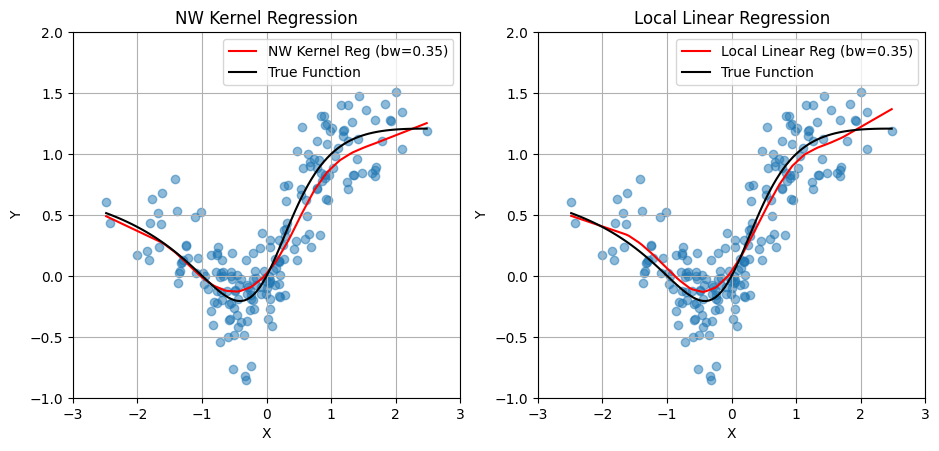

In [7]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
bw_silverman = (4/(3*len(X)))**0.2*np.std(X)
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
yknots0 = kern_reg(xknots0, X, Y, bw_silverman, gauss_kern)
f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
axs[0].plot(x, f0(x), color='r', label='NW Kernel Reg (bw={:.2f})'.format(bw_silverman))
axs[0].set_title('NW Kernel Regression')
# Local Linear Regression
xknots1 = xknots0
yknots1 = ll_reg(xknots1, X, Y, bw_silverman, gauss_kern)
f1 = interp1d(xknots1, yknots1, kind='linear', fill_value='extrapolate')
axs[1].plot(x, f1(x), color='r', label='Local Linear Reg (bw={:.2f})'.format(bw_silverman))
axs[1].set_title('Local Linear Regression')
for ax in axs:
    ax.scatter(X, Y, alpha=0.5)
    ax.plot(x, g(x), 'k', label='True Function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc=0)

## Questions

<b>Question 1.1</b>. (Parametric regression) In general, increasing the number of basis functions in the regression gives us more flexibility to better fit the data. However, having too many parameters in the model oftentimes leads to overfitting, which usually has poor predictive performance and is over-sensitive to small noise in the data. To observe the overfitting phenomenon, in polynomial fit, try to use different degrees of the polynomials; in piecewise-linear regression, try to use difference number of knots. Then reproduce the scatter plot with fitted regression function. Compare and comment on the results.

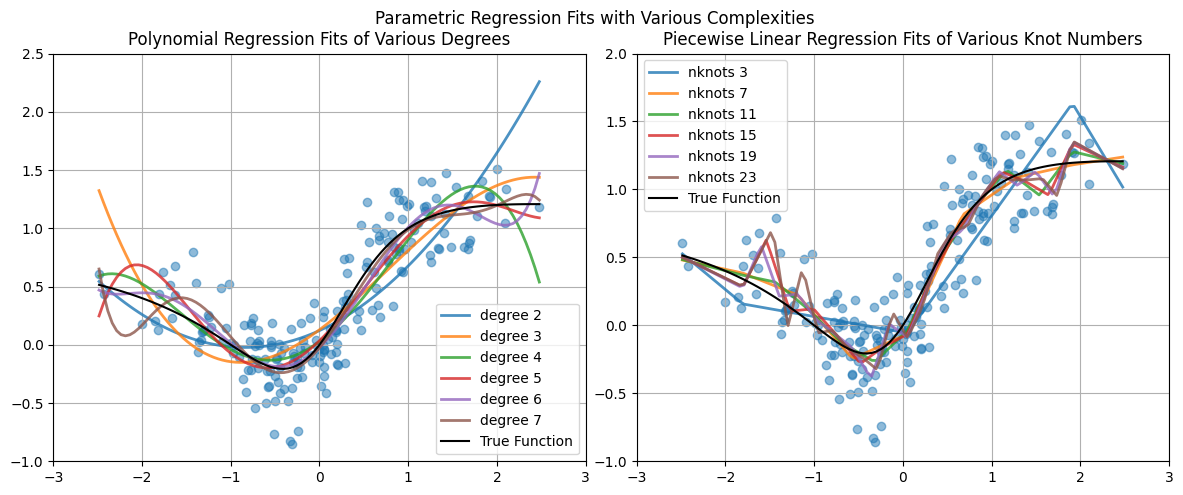

In [8]:
# Initialize figure for comparing parametric regression fits with various complexities
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.suptitle('Parametric Regression Fits with Various Complexities')

# Polynomial Regression Fits of Various Degrees
ax[0].scatter(X, Y, alpha=0.5)
for degree in np.arange(2, 8, 1):
    p = np.polyfit(X, Y,deg=degree)
    ax[0].plot(x, np.polyval(p, x), lw=2,alpha=0.8, label='degree {}'.format(degree))
ax[0].plot(x, g(x), 'k', label='True Function')
ax[0].legend(loc=0)
fig.tight_layout()
ax[0].set_title('Polynomial Regression Fits of Various Degrees')

# Piecewise Linear Regression Fits of Various Knot Numbers
ax[1].scatter(X, Y, alpha=0.5)
for nknots in np.arange(3, 24, 4):
    xknots = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), nknots)
    ps, fs = pwlin_fit(X, Y, xknots)
    ax[1].plot(x, sum([f(x)*p for (f, p) in zip(fs, ps)]), lw=2,alpha=0.8, label='nknots {}'.format(nknots))
ax[1].plot(x, g(x), 'k', label='True Function')
ax[1].legend(loc=0)
ax[1].set_title('Piecewise Linear Regression Fits of Various Knot Numbers')

# Finalize and show plot
plt.show()

**Analysis of Results**

The plots illustrate the Bias-Variance Tradeoff by varying model complexity against the true function $f(x)$.

**1. Polynomial Regression (Left Plot)**

- Underfitting: At degree 2, the model is too simple (high bias) and fails to capture the inflection points of the sine-like wave.
- Overfitting: At degree 6, the curve begins to oscillate unnecessarily, particularly at the boundaries ($x > 2$). 
It fits the random noise $\epsilon$ rather than the underlying trend.

**2. Piecewise Linear Regression (Right Plot)**

- Underfitting: With 3 knots, the segments are too coarse to approximate the smooth curve.
- Overfitting: With more than 10 knots, the model becomes "jagged" and over-sensitive (high variance). It chases individual noisy data points, resulting in a fit that lacks smoothness.

**Conclusion**

Increasing the number of parameters (degrees $d$ or knots $k$) increases flexibility. However, excessive flexibility leads to overfitting, where the model captures noise instead of the signal. Visually, the optimal complexity appears to be around $d=3$ for the polynomial regression and $7$ for the piecewise linear regression, balancing fit and smoothness.

<b>Question 1.2</b>. For nonparametric regression,
<ul>
<li>Try different bandwidth values in the kernel regression. Reproduce the scatter plot with fitted regression function. Compare and comment on the results. For what values of the bandwidth do we observe overfitting? For what values of the bandwidth do we observe a poor fit?</li>
<li>Try to use different kernels, for example

$$ K(x) = (x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{elsewhere.} $$

Which has more impact: the bandwidth $h$ or the kernel $K$?
</ul>

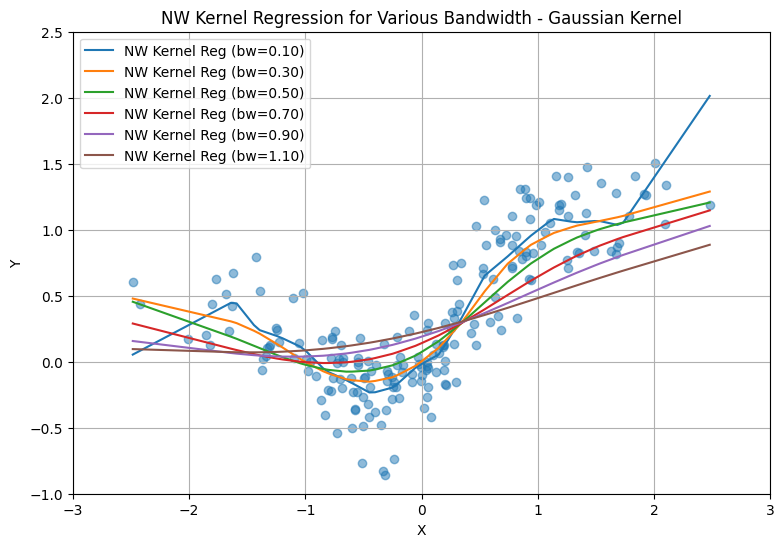

In [9]:
fig, axs = plt.subplots(1,1, figsize=(9, 6))

# Various Bandwidths for NW Kernel Regression
bandwidth = np.arange(0.1, 1.2, 0.2)

# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
axs.scatter(X, Y, alpha=0.5)

# Plot NW Kernel Regression for each bandwidths
for bw in bandwidth:
    yknots0 = kern_reg(xknots0, X, Y, bw, gauss_kern)
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    axs.plot(x, f0(x), label='NW Kernel Reg (bw={:.2f})'.format(bw))
axs.set_title('NW Kernel Regression for Various Bandwidth - Gaussian Kernel')
axs.set_xlabel('X')
axs.set_ylabel('Y')
axs.legend()
plt.show()

**Analysis of Bandwidth ($h$) Influence** 

The graph demonstrates the bias-variance tradeoff controlled by the bandwidth parameter in kernel regression.

**1. Overfitting (Small Bandwidth)**

At $h = 0.10$ (blue line), the regression curve is extremely jagged and volatile.The window of observation is too narrow. The model is reacting to local noise and individual data points rather than capturing the underlying trend. This represents high variance.

**2. Underfitting / Poor Fit (Large Bandwidth)**

At $h = 0.90$ (purple line) and $h = 1.10$ (brown line), the curves are excessively smooth and flattened. The window is too wide, causing the model to average over a large range of data. This "oversmoothing" causes the model to miss key structural features (like the peaks and valleys of the sine wave). This represents high bias.

**3. Optimal Fit**

The values $h = 0.30$ (orange) and $h = 0.50$ (green) appear to offer the best balance, capturing the S-shape of the function without tracking the noise.

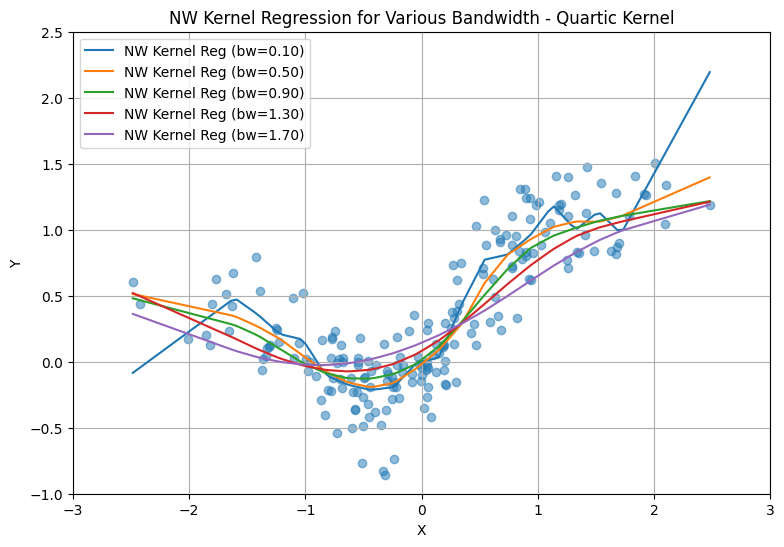

In [10]:
# Define the new kernel function
def quartic_kernel(u):
    """
    Implements the kernel K(u) = (u+1)^2 * (1-u)^2 for |u| <= 1 and 0 otherwise.
    """
    # Apply the formula where |u| <= 1, otherwise return 0
    return np.where(np.abs(u) <= 1, (u+1)**2 * (1 - u)**2, 0)
    
fig, axs = plt.subplots(1,1, figsize=(9, 6))

# Various Bandwidths for NW Kernel Regression
bandwidth = np.arange(0.1, 2, 0.4)
    
# NW Kernel Regression
xknots0 = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 20)
axs.scatter(X, Y, alpha=0.5)

# Plot NW Kernel Regression for each bandwidths with the quartic kernel
for bw in bandwidth:
    yknots0 = kern_reg(xknots0, X, Y, bw, quartic_kernel)
    f0 = interp1d(xknots0, yknots0, kind='linear', fill_value='extrapolate')
    axs.plot(x, f0(x), label='NW Kernel Reg (bw={:.2f})'.format(bw))
axs.set_title('NW Kernel Regression for Various Bandwidth - Quartic Kernel')
axs.set_xlabel('X')
axs.set_ylabel('Y')
axs.legend()
plt.show()

**Which has more impact: Bandwidth ($h$) or Kernel ($K$)?**

The bandwidth ($h$) has a much larger impact than the choice of the kernel ($K$).

**The Impact of Bandwidth (Critical)**: As observed in both graphs, changing $h$ radically alters the nature of the model. You shift from nearly perfect interpolation of noise (extreme variance) to an almost flat line (extreme bias). The parameter $h$ directly controls the complexity of the model.

**The Impact of the Kernel (Secondary)**: If you compare the green curve of the Gaussian graph ($h=0.50$) and the orange curve of the Quartic graph ($h=0.50$), they look very similar. As long as the kernel is symmetric, unimodal (bell-shaped), and integrates to one, its influence on the final shape of the curve is minimal compared to the influence of the window width.

The choice of kernel may have a slight influence on boundary effects (near the edges of the data) or computational cost (the Quartic kernel is faster to calculate than the Gaussian exponential), but it changes the general shape of the regression very little.

# 2. American Option Pricing

In [11]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=float)
    paths[0] = S0
    
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [12]:
S0 = 100
vol = 0.2
r = 0.1
q = 0.02
K = 100
T = 1

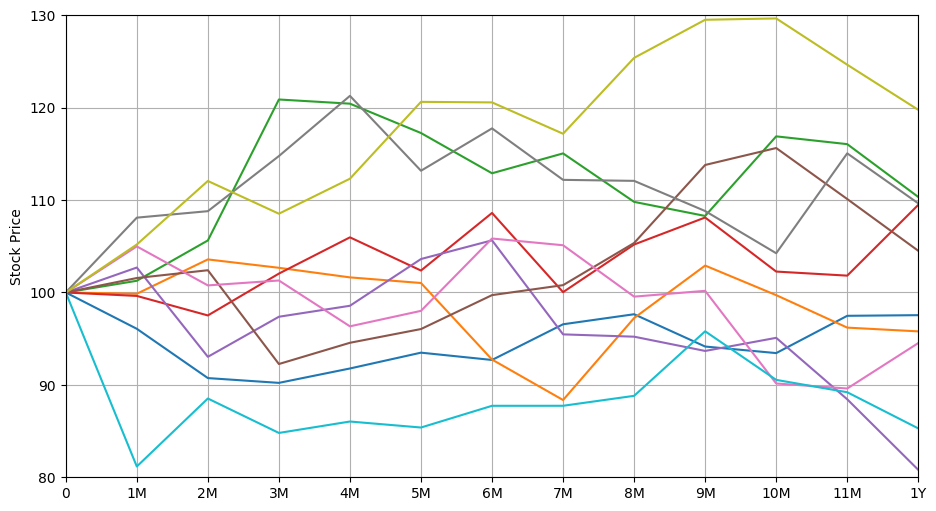

In [13]:
ts = np.linspace(0, 1, 13)
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q)
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(ts, paths[:, :10])
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

### Price of European put option

In [14]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

np.float64(4.293643966181576)

### Price of Bermudan put option with monthly exercises

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [15]:
# Longstaff-Schwartz algorithm for American put option pricing
payoff = np.maximum(K-paths[-1], 0)

# Backward induction
for i in range(len(ts)-2, 0, -1):
    # Discount the payoff to the previous time step
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount

    # Fit a polynomial regression of degree 2 to estimate continuation value
    p = np.polyfit(paths[i], payoff, deg=2)

    # Compute continuation value and exercise value
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)

    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

np.float64(4.824481733448404)

#### Tsitsiklis-van Roy algorithm

The price from the TVR algorithm is generally too high because regression errors accumulate in the backward induction.

In [16]:
# Tsitsiklis-van Roy algorithm for American put option pricing
V = np.maximum(K-paths[-1], 0)

for i in range(len(ts)-2, 0, -1):
    # Discount factor
    discount = np.exp(-r*(ts[i+1]-ts[i]))

    # Estimate continuation value by regression
    p = np.polyfit(paths[i], V*discount, deg=2)

    # Compute continuation value and exercise value
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)

    # Update value function
    V = np.maximum(exerval, contval)
np.mean(V)*np.exp(-r*(ts[1]-ts[0]))

np.float64(6.257028200289532)

## Questions

### <b>Question 2.1</b>. Adapt the Longstaff-Schwartz and TVR code to use different regression methods:

<b>(a).</b> Black-Scholes put prices.
<br>
Use the constant 1.0 and the Black-Scholes price of a European put option with volatility $\bar\sigma = 0.2$ and maturity $T-t$ as the two basis functions at time $t$. For your convenience, the Black-Scholes pricing formula is included in the cell below.

<b>(b).</b> Piecewise Linear regression.

Note: choose the number of knots appropriately in the regression.</li>

<b>(c).</b> Kernel regression with Gaussian kernel.

Note: Choose the bandwidth appropriately.</li>

In [17]:
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S0: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

#### Define a function to estimate continuation value using different regression methods

In [18]:
# Define a function to estimate continuation value using different regression methods
def estimate_continuation_value(x, y, method, K, T_remaining):
    """Encapsulates different regression methods for robustness."""
    # Polynomial Regression
    if method == 'polynomial':
        p = np.polyfit(x, y, deg=2)
        return np.polyval(p, x)
    
    # Black-Scholes Put price regression
    elif method == 'bs':
        put_bs = blackscholes_price(K, T_remaining, x, vol, callput='put')
        X = np.column_stack([np.ones_like(x), put_bs])
        p = np.linalg.lstsq(X, y, rcond=None)[0]
        return X @ p
    
    # Piecewise Linear Regression
    elif method == 'piecewise':
        nb_knots = 8
        xknots = np.percentile(x, np.linspace(2.5, 97.5, nb_knots))
        ps, fs = pwlin_fit(x, y, xknots)
        return sum([f(x) * p for (f, p) in zip(fs, ps)])
    
    # Kernel Regression
    elif method == 'kernel':
        nb_knots = 20
        bw = (4 / (3 * len(x)))**0.2 * np.std(x)
        xknots = np.linspace(np.percentile(x, 2.5), np.percentile(x, 97.5), nb_knots)
        yknots = kern_reg(xknots, x, y, bw, gauss_kern)
        return interp1d(xknots, yknots, kind='linear', fill_value='extrapolate')(x)

#### Function for plotting regression results


In [19]:
def _plot_regression(axis, x, y, exer, cont, method, time):
    """Helper to handle plotting logic."""
    axis.scatter(x, y, alpha=0.05, label='Payoff Value')
    axis.plot(x, cont, 'r.', markersize=2, label='Continuation Fit')
    axis.plot(x, exer, 'g.', markersize=2, label='Exercise Value')
    axis.set_title(f"{method.capitalize()} - Time {time}")
    axis.set_xlabel("Stock Price")
    axis.legend()

#### Longstaff-Schwartz and Tsitsiklis-Van Roy algorithm for American put option pricing


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def american_option(paths, ts, K, r, method='polynomial', algo='LS'):
    """
    American put option pricing using either Longstaff-Schwartz (LS) 
    or Tsitsiklis-Van Roy (TVR).
    """
    payoff = np.maximum(K - paths[-1], 0)
    
    # Setup plotting
    plot_indices = [len(ts) - 2, (len(ts) - 2) // 2, 1]
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    # Pricing using Backward Induction
    for i in range(len(ts) - 2, 0, -1):
        dt = ts[i+1] - ts[i]
        payoff *= np.exp(-r * dt)

        # Calculate exercise value
        exerval = np.maximum(K - paths[i], 0)
        
        # Estimate Continuation Value via Regression
        contval = estimate_continuation_value(paths[i], payoff, method, K, ts[-1] - ts[i])

        # Visualization
        if i in plot_indices:
            idx = plot_indices.index(i)
            _plot_regression(ax[idx], paths[i], payoff, exerval, contval, f"{algo.upper()}-{method}", ts[i].round(2))

        # Decision Rule depending on the algorithm
        if algo.upper() == 'LS':
            # Longstaff-Schwartz: Update only if exercising is better
            ind = exerval > contval
            payoff[ind] = exerval[ind]
            
        elif algo.upper() == 'TVR':
            # Tsitsiklis-Van Roy: Payoff becomes the max of exercise vs continuation estimate
            payoff = np.maximum(exerval, contval)

    plt.tight_layout()
    plt.show()

    # Final Discount to T=0
    return np.mean(payoff * np.exp(-r * (ts[1] - ts[0])))

#### Analyze different regression methods for Longstaff-Schwartz

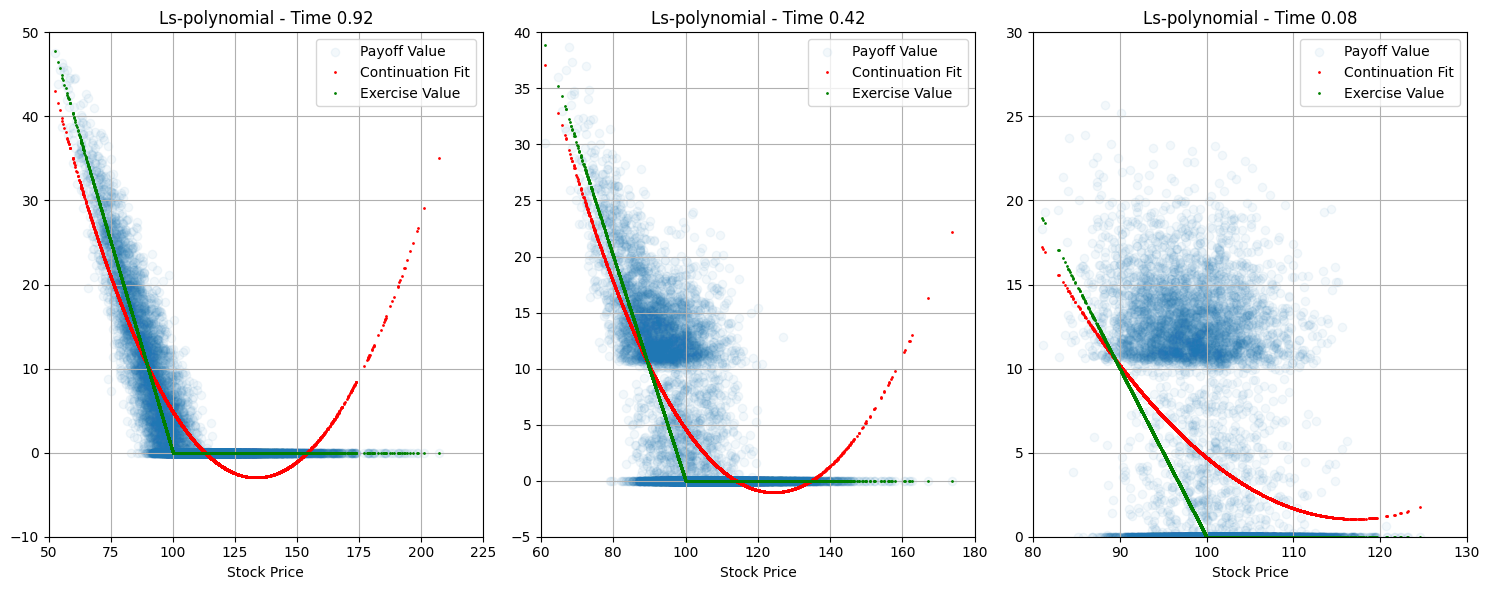

American Put Option Price using polynomial regression: 4.8245


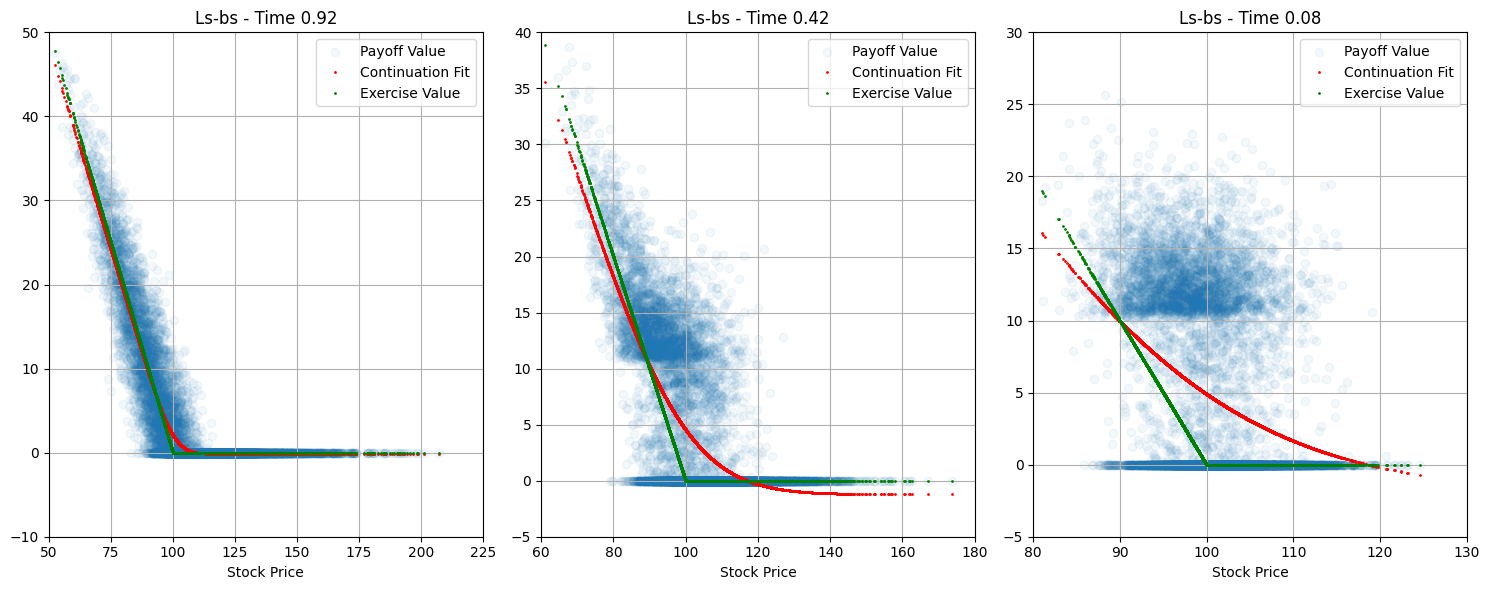

American Put Option Price using bs regression: 4.9060


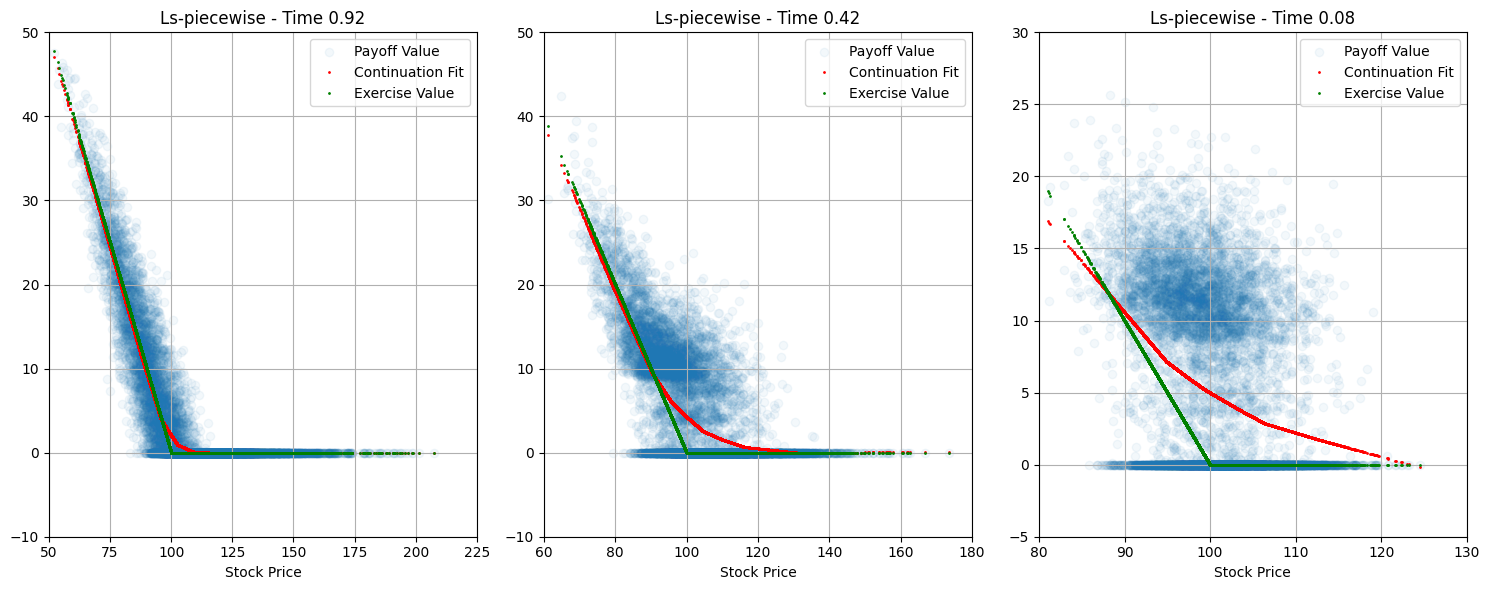

American Put Option Price using piecewise regression: 5.1047


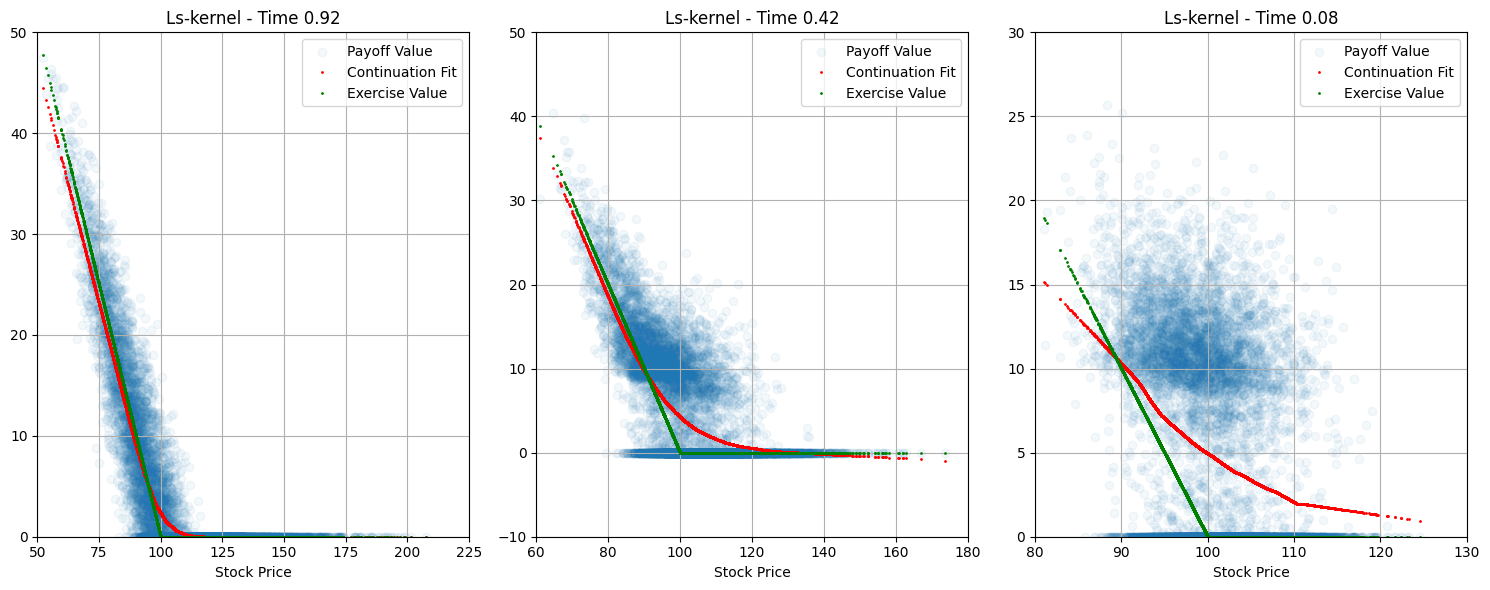

American Put Option Price using kernel regression: 5.0781


In [21]:
# Comparaison of different regression methods using Longstaff-Schwartz algorithm
methods = ['polynomial', 'bs', 'piecewise', 'kernel']
for method in methods:
    price = american_option(paths, ts, K, r, method=method, algo='LS')
    print('American Put Option Price using {} regression: {:.4f}'.format(method, price))


#### Analyze different regression methods for Tsitsiklis-Van Roy

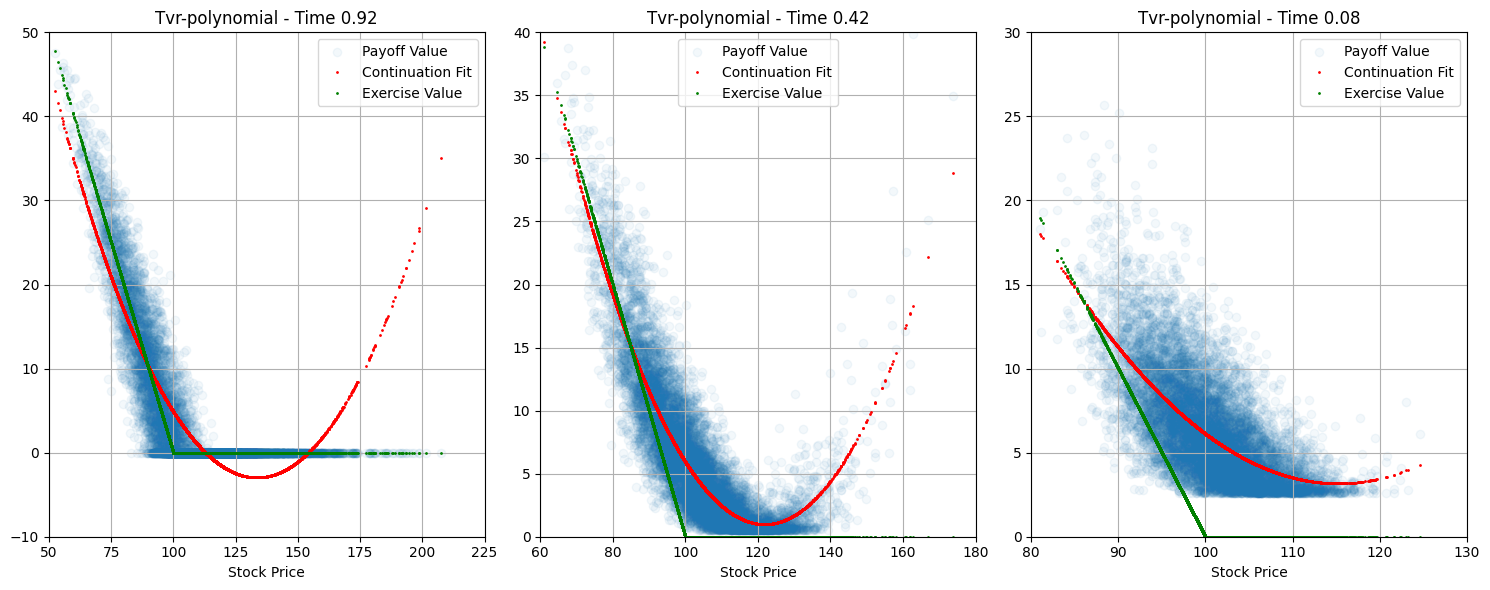

American Put Option Price using polynomial regression: 6.2570


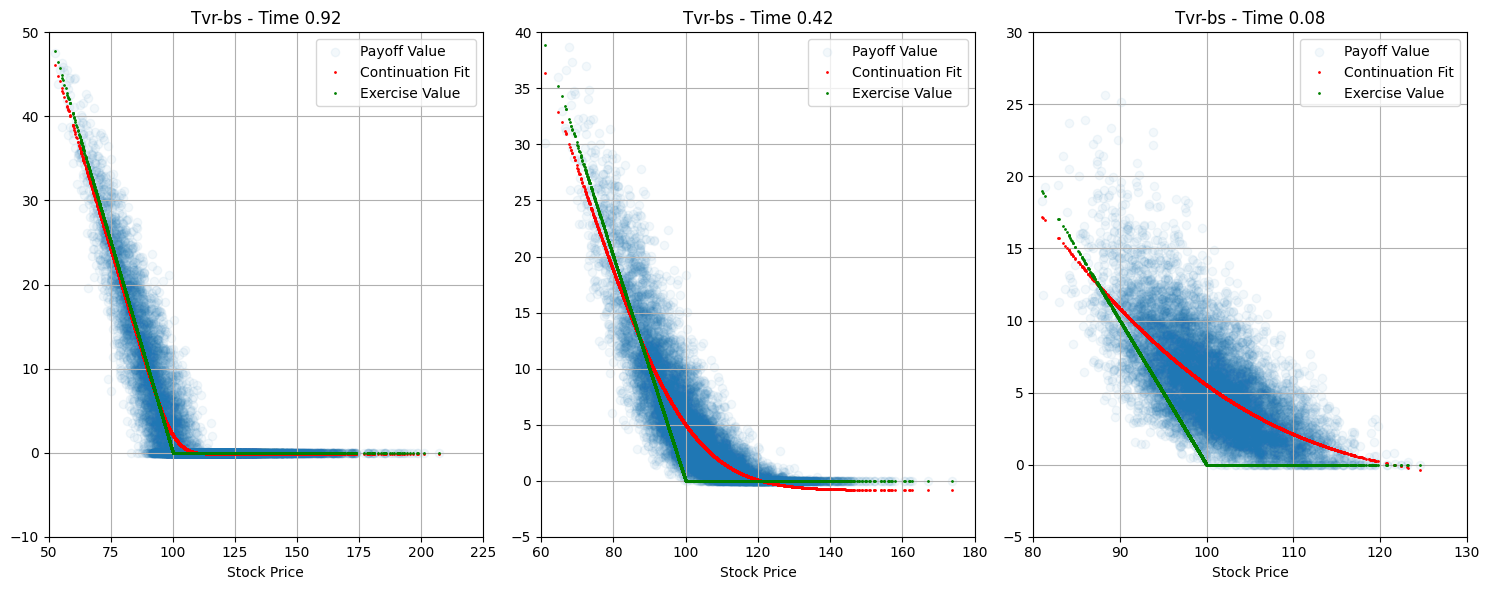

American Put Option Price using bs regression: 5.5239


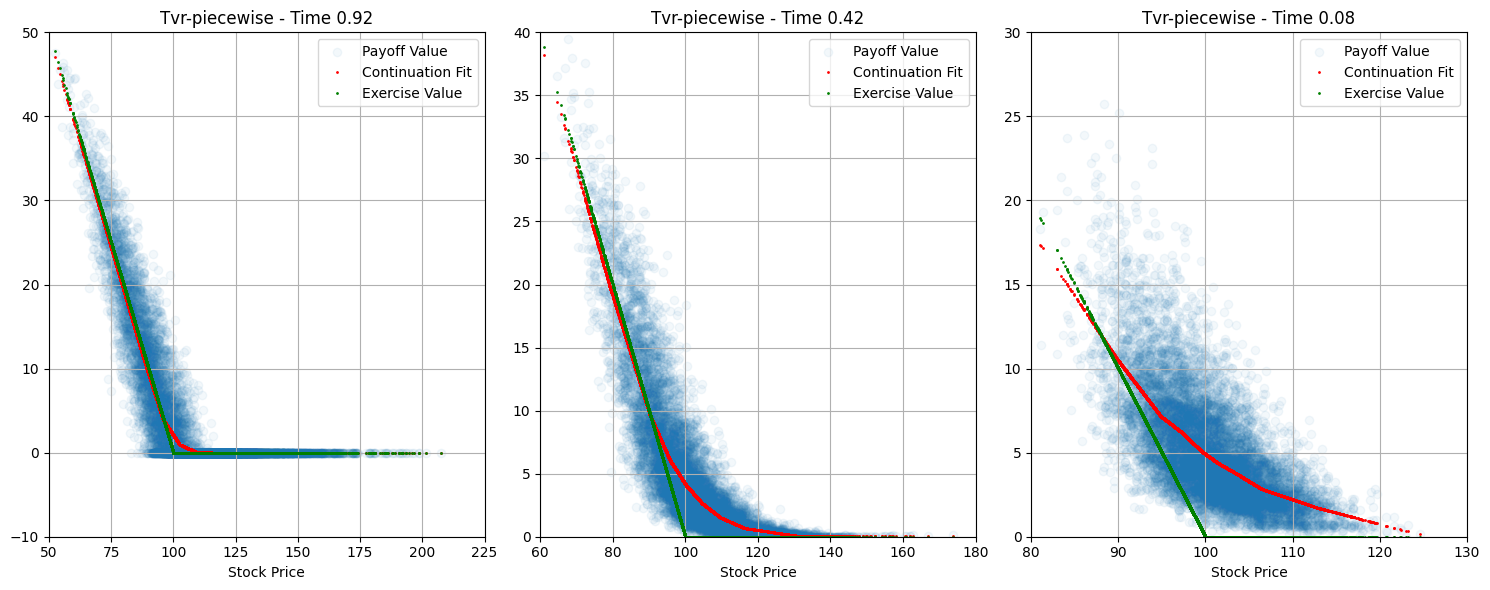

American Put Option Price using piecewise regression: 5.0951


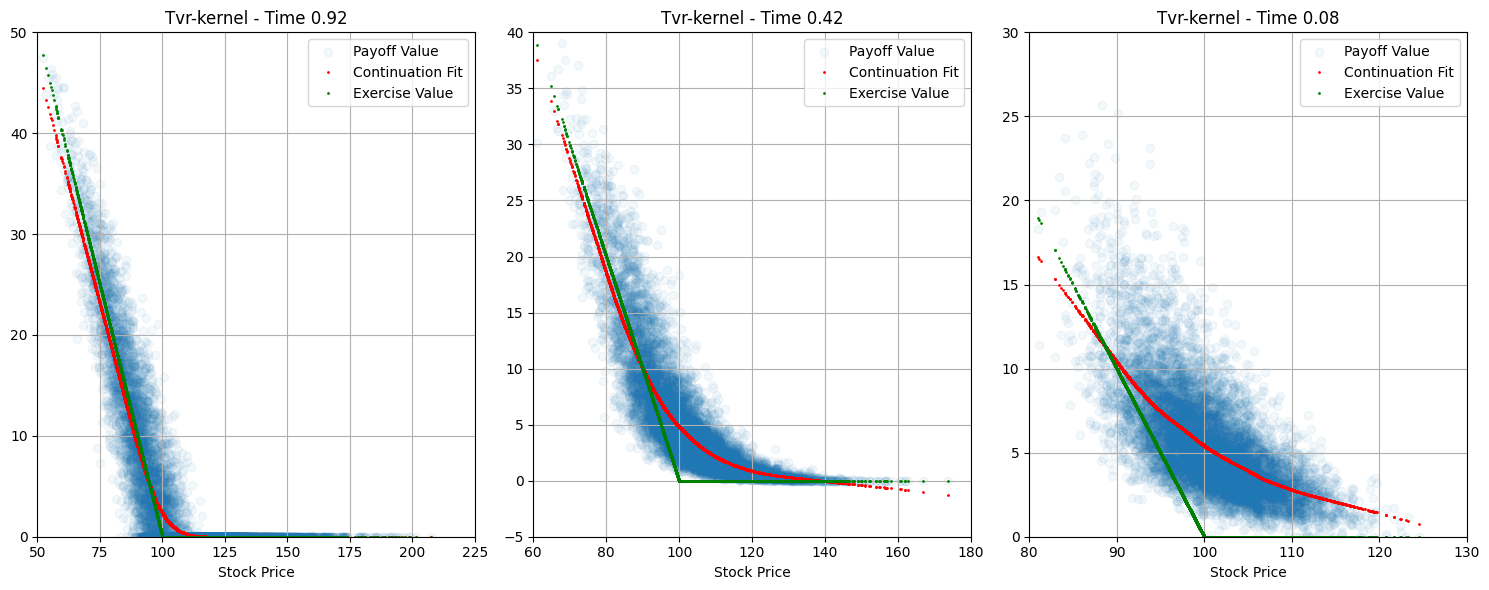

American Put Option Price using kernel regression: 5.5295


In [22]:
for method in methods:
    price = american_option(paths, ts, K, r, method=method, algo='TVR')
    print('American Put Option Price using {} regression: {:.4f}'.format(method, price))

### <b>Question 2.2</b>. Both TVR and Longstaff-Schwartz algorithms provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

Perform an independent Monte Carlo simulation using this estimate of continuation value from <b>both</b> algorithms as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. The basis functions for regression can be chosen to be the quadratic polynomial as in the sample code.

Show your code and result with at least 100000 simulations.

#### Train exercise policies

In [23]:
def train_exercise_policy(paths, ts, K, r, algo='LS'):
    """Trains regression coefficients to define an exercise policy."""
    payoff = np.maximum(K - paths[-1], 0)
    
    # Store coefficients for each time step
    policies = {}

    for i in range(len(ts) - 2, 0, -1):
        dt = ts[i+1] - ts[i]
        payoff *= np.exp(-r * dt)
        
        exerval = np.maximum(K - paths[i], 0)
        
        # Fit regression (Policy Training)
        coefs = np.polyfit(paths[i], payoff, deg=2)
        policies[i] = coefs
        contval = np.polyval(coefs, paths[i])

        # Update payoff for the next backward step based on algorithm
        if algo.upper() == 'LS':
            ind = exerval > contval
            payoff[ind] = exerval[ind]
        else: # TVR
            payoff = np.maximum(exerval, contval)
            
    return policies

#### Price using trained policy


In [24]:
def price_with_policy(paths, ts, K, r, policies):
    """Out-of-sample valuation using a pre-trained policy."""

    # Track when each path is exercised
    exercise_times = np.full(paths.shape[1], len(ts) - 1)
    
    for i in range(1, len(ts) - 1):
        exerval = np.maximum(K - paths[i], 0)
        
        # Estimate continuation value using the trained policy
        contval_est = np.polyval(policies[i], paths[i])
        
        # Exercise if immediate payoff > estimated continuation
        exercise_now = exerval > contval_est
        
        # Update paths that haven't been exercised yet
        still_active = (exercise_times == len(ts) - 1)
        exercise_times[still_active & exercise_now] = i
            
    # Calculate discounted payoffs based on the first exercise time
    final_payoffs = np.zeros(paths.shape[1])
    for p in range(paths.shape[1]):
        tau_idx = exercise_times[p]
        tau_time = ts[tau_idx]
        val = np.maximum(K - paths[tau_idx, p], 0)
        final_payoffs[p] = val * np.exp(-r * tau_time)
        
    return np.mean(final_payoffs)

In [25]:
# Generate Training Paths and Test Paths
paths_train = blackscholes_mc(ts, 100000, S0, vol, r, q) 
paths_test = blackscholes_mc(ts, 100000, S0, vol, r, q) 

# Estimate Price fir LS
policy_ls = train_exercise_policy(paths_train, ts, K, r, algo='LS')
price_ls = price_with_policy(paths_test, ts, K, r, policy_ls)
print('American Put Option Price using Longstaff-Schwartz policy: {:.4f}'.format(price_ls))

# Estimate Price for TVR
policy_tvr = train_exercise_policy(paths_train, ts, K, r, algo='TVR')
price_tvr = price_with_policy(paths_test, ts, K, r, policy_tvr)
print('American Put Option Price using Tsitsiklis-van Roy policy: {:.4f}'.format(price_tvr))    

American Put Option Price using Longstaff-Schwartz policy: 4.9622
American Put Option Price using Tsitsiklis-van Roy policy: 4.9747


Any price derived from this method is a lower bound because:

- Suboptimal Policy: The regression provides an approximation of the optimal exercise rule. Any rule that isn't perfectly optimal will, by definition, capture less value than the theoretical maximum.
- Supremum Definition: The price of an American option is the supremum over all stopping times. Since we are testing a specific (and likely slightly imperfect) stopping time $\tau$ generated by our regression, the expected value $\mathbb{E}[g(X_\tau)]$ must be $\le$ the true price.

### <b>Question 2.3</b> Oftentimes parametric regressions may not produce globally accurate estimates of continuation values for all possible values of state variables. One approach to improve the accuracy is to run regression only in the region where option is in the money. When the option is out of money, one should always choose to continue, therefore there is no need to estimate the continuation value.

Modify the Longstaff-Schwartz code to implement this improvement.

Show your code and results with the following basis functions:

<b>(a).</b> quadratic polynomial basis functions;

<b>(b).</b> basis functions given in Question 2.1(a)

For each case, identify and plot the exercise and continuation regions at time $t=0.5$. Comment on the result.

In [26]:
def opti_longstaff_schwartz(paths, ts, K, r, method='polynomial'):
    """Longstaff-Schwartz algorithm for American put option pricing, regression only on in-the-money paths"""
    payoff = np.maximum(K-paths[-1], 0)

    # Backward induction
    for i in range(len(ts)-2, 0, -1):
        # Discount the payoff to the previous time step
        discount = np.exp(-r*(ts[i+1]-ts[i]))
        payoff = payoff*discount

        # Identify in-the-money paths
        itm_mask = paths[i] < K

        # Fit a polynomial regression of degree 2 to estimate continuation value
        if method == 'polynomial':
            # Fit only on in-the-money paths
            p = np.polyfit(paths[i][itm_mask], payoff[itm_mask], deg=2)
            contval_itm = np.polyval(p, paths[i][itm_mask])
            
            # For plotting purpose
            sort_idx = np.argsort(paths[i][itm_mask])
            plot_X = paths[i][itm_mask][sort_idx]
            plot_Y = contval_itm[sort_idx]
            
        elif method == 'bs':
            # Fit only on in-the-money paths
            put_bs = blackscholes_price(K, ts[-1]-ts[i], paths[i][itm_mask],0.2, callput='put')
            X = np.column_stack([np.ones_like(paths[i][itm_mask]), put_bs])
            p = np.linalg.lstsq(X, payoff[itm_mask], rcond=None)[0]
            contval_itm = X @ p

            sort_idx = np.argsort(paths[i][itm_mask])
            plot_X = paths[i][itm_mask][sort_idx]
            plot_Y = contval_itm[sort_idx]

        exerval_itm = np.maximum(K-paths[i][itm_mask], 0)
        ind = exerval_itm > contval_itm

        # Compute continuation value and exercise value
        current_payoff_subset = payoff[itm_mask]
        current_payoff_subset[ind] = exerval_itm[ind]
        payoff[itm_mask] = current_payoff_subset
    
    # Plot the exercise vs continuation regions at the middle time step
    plt.figure(figsize=(10, 6))
    plt.title(f"Exercice vs Continuation Regions à t={ts[len(ts)//2]} (Méthode: {method})")
    
    # Exercise value
    s_grid = np.linspace(np.min(paths[i][itm_mask]), np.max(paths[i][itm_mask]), 100)
    plt.plot(s_grid, np.maximum(K - s_grid, 0), 'g--', label='Exercise Value (Intrinsic)', linewidth=2)
    
    plt.plot(plot_X, plot_Y, 'r-', label='Estimated Continuation Value')

    # scatter otm paths
    plt.scatter(paths[i][~itm_mask], payoff[~itm_mask], alpha=0.5, s=10, label='Out-of-the-Money Paths')
    # scatter itm paths in different colors
    plt.scatter(paths[i][itm_mask], payoff[itm_mask], color='orange', alpha=0.7, s=10, label='In-the-Money Paths')
    
    # show continuatio region
    plt.fill_between(s_grid, 0, 30, where=(np.maximum(K - s_grid, 0) >= np.interp(s_grid, plot_X, plot_Y)), color='yellow', alpha=0.2, label='Exercise Region')

    plt.xlabel("Stock Price ($S_t$)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True) 
    plt.tight_layout()
    plt.show()
    return np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

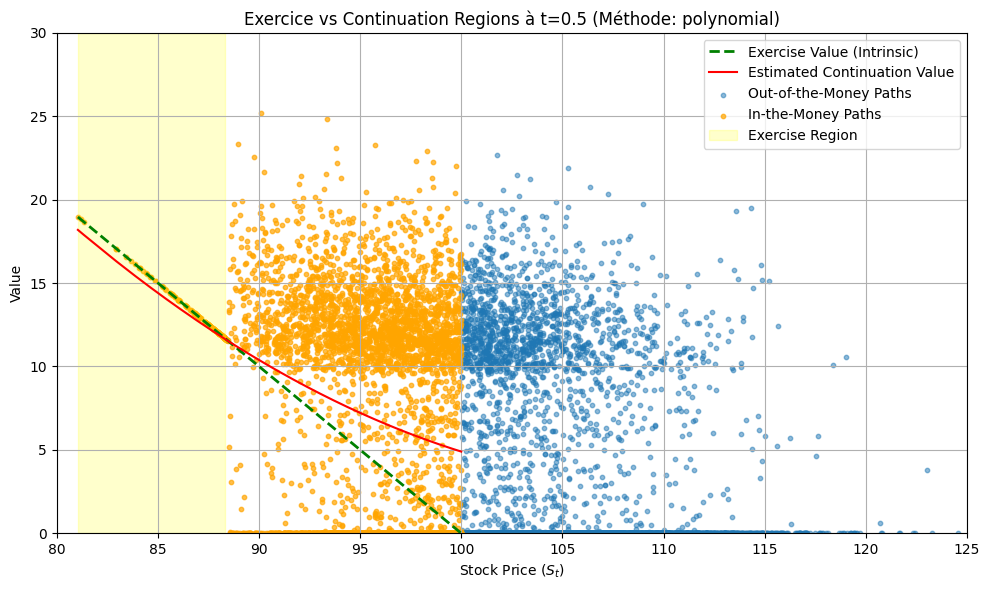

American Put Option Price using polynomial regression: 5.0682


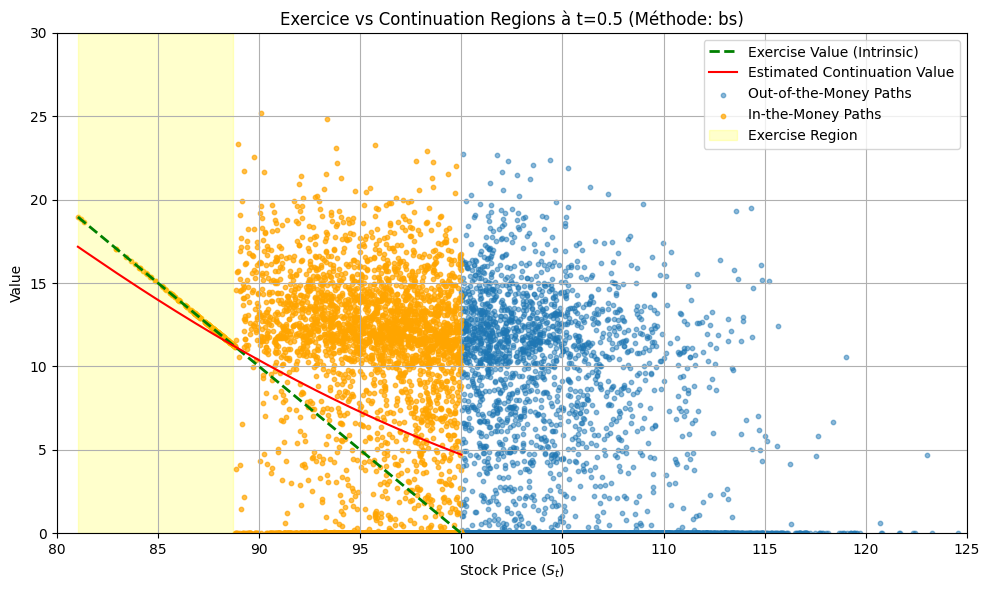

American Put Option Price using bs regression: 5.0985


In [27]:
# Comparaison of different regression methods using Tsitsiklis-van Roy algorithm
methods = ['polynomial', 'bs']
for method in methods:
    price = opti_longstaff_schwartz(paths, ts, K, r, method=method)
    print('American Put Option Price using {} regression: {:.4f}'.format(method, price))

**Conclusion on ITM Regression**

Running the regression only on ITM paths (as seen in the orange clusters) significantly improves the stability of the model. It prevents the "pull" of the zero-payoff OTM paths (blue dots) from flattening the continuation curve, thereby providing a sharper and more reliable estimate of the exercise boundary at $S_t \approx 89$

### <b>Question 2.4</b>. Use the Longstaff-Schwartz algorithm to price an Bermudan-Asian call option. The underlying security price is assumed to follow the geometric Brownian motion

$$\frac{dS_t}{S_t}=(r-q)dt+\sigma dW_t$$

with $S_0=100$, $r=0$, $q=0$ and $\sigma=0.2$. The option has a strike of $K=100$ and a final expiration date of $T=1$ and can be exercised every month before the final maturity, i.e.
$$t_1=\frac{1}{12},\, t_2=\frac{2}{12},\, \ldots,\, t_{12}=1$$

The cashflow from exercising the option at time $t_n$, $n=1,\ldots,12$, is $\max\left(0, A_{t_n}-K\right)$ with $A_{t_n}=\frac{1}{n}\sum_{i=1}^nS_{t_i}$.

<b>(a).</b>
As the basis functions in the regression at time $t_n$, use the constant 1.0 and the Black-Scholes value of a European call option with strike $K$, maturity $T-t_n$, volatility $\bar\sigma = 0.1$, and the spot value
$$
Z_{t_n}\equiv \frac{nA_{t_n}+(12-n)S_{t_n}}{12}
$$

As in Question 2.4, after you have obtained estimations of continuation values from the Longstaff-Schwartz algorithm, run an independent Monte Carlo simulation with at least 100000 paths to obtain a low-biased price. Explain the use of $Z_{t_n}$ instead of simply $A_{t_n}$ or $S_{t_n}$.



In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [ ]:
# Params for the Asian option
S0, K, T = 100, 100, 1
r, q, sigma = 0, 0, 0.2
n_steps = 12
dt = T / n_steps
ts = np.linspace(dt, T, n_steps)

# Train a policy
n_train = 100000
paths_train = blackscholes_mc(ts, n_train, S0, sigma, r, q)

A_train = np.cumsum(paths_train, axis=0) / np.arange(1, n_steps + 1)[:, None]
# Store regression coefficients to define the "Policy"
policies = {}
payoff_train = np.maximum(A_train[-1] - K, 0)

# Training Phase
for i in range(n_steps - 2, -1, -1):
    payoff_train *= np.exp(-r * dt)

    # State variable Z_tn (Question 2.4a)
    n_idx = i + 1 
    Z_tn = (n_idx * A_train[i] + (12 - n_idx) * paths_train[i+1]) / 12
    
    # Basis functions: Constant and Black-Scholes value
    bs_val = blackscholes_price(K, T - ts[i], Z_tn, sigma, r=r, q=0, callput='call')
    X = np.column_stack([np.ones_like(Z_tn), bs_val])
    
    # Regression on In-the-Money paths only (Question 2.3)
    itm = np.maximum(A_train[i] - K, 0) > 0
    if np.any(itm):
        coefs = np.linalg.lstsq(X[itm], payoff_train[itm], rcond=None)[0]
        policies[i] = coefs
        cont_val = X @ coefs
        
        # Update payoff for next backward step
        exer_val = np.maximum(A_train[i] - K, 0)
        mask = exer_val > cont_val
        payoff_train[mask] = exer_val[mask]
    else:
        policies[i] = None

# Evaluation Phase
n_test = 100000
paths_test = blackscholes_mc(ts, n_test, S0, sigma, r, q)
A_test = np.cumsum(paths_test, axis=0) / np.arange(1, n_steps + 1)[:, None]

# Track the first exercise time for each path
exercise_times = np.full(n_test, n_steps - 1)

for i in range(n_steps - 1):
    if i in policies and policies[i] is not None:
        n_idx = i + 1
        Z_tn_test = (n_idx * A_test[i] + (12 - n_idx) * paths_test[i+1]) / 12
        
        bs_val_test = blackscholes_price(K, T - ts[i], Z_tn_test, sigma, r=r, q=0, callput='call')
        X_test = np.column_stack([np.ones_like(Z_tn_test), bs_val_test])
        
        cont_est = X_test @ policies[i]
        exer_val = np.maximum(A_test[i] - K, 0)
        
        # Policy: Exercise if intrinsic value > estimated continuation value
        should_exercise = (exer_val > 0) & (exer_val > cont_est)
        active = (exercise_times == n_steps - 1)
        exercise_times[active & should_exercise] = i

# Calculate the final discounted price (Lower Bound)
final_payoffs = np.zeros(n_test)
for i in range(n_test):
    idx = exercise_times[i]
    tau = ts[idx]
    val = np.maximum(A_test[idx, i] - K, 0)
    final_payoffs[i] = val * np.exp(-r * tau)

lower_bound_price = np.mean(final_payoffs)
std_error = np.std(final_payoffs) / np.sqrt(n_test)

print(f"Lower Bound Price (Q2.4a): {lower_bound_price:.4f}")

Lower Bound Price (Q2.4a): 4.9179
95% Confidence Interval: [4.8766, 4.9593]


**Explanation of $Z_{t_n}$ usage**

- Approximation of Final Average: $Z_{t_n}$ acts as the best estimate at time $t_n$ of what the final average $A_{t_{12}}$ will be. It combines the "known" part (the average realized so far, $A_{t_n}$) with a proxy for the "unknown" part (assuming the future prices stay near the current spot $S_{t_n}$).
- Dimensionality Reduction: By combining $S_{t_n}$ and $A_{t_n}$ into a single state variable $Z_{t_n}$, we can use the standard 1D Black-Scholes formula as a basis function. This effectively captures the "optionality" of the Asian payoff more accurately than a simple polynomial, leading to a tighter lower bound.
- Correlation with Payoff: The final payoff is $\max(0, A_{t_{12}} - K)$. Since $Z_{t_n}$ is a proxy for $A_{t_{12}}$, the Black-Scholes value $BS(Z_{t_n}, K, \dots)$ is highly correlated with the true continuation value, making the regression significantly more robust.

<b>(b).</b> Implement a feed-forward neural network to estimate the conditional value at each time step. The network should take both $S_{t_n}$ and $A_{t_n}$ as inputs. As in part (a), after all estimations of continuation values are obtained, run an indepedent Monte Carlo simulation to get a low-biased price.

Technical Tips: You should use tensorflow to implement the neural networks. There is a tensorflow example in the test notebook for your reference. For this problem, we recommend the following hyperparameters: 3 hidden layers with 20 neurons and RELU activation on each layer. To control the time of training, we recommend training size of 50000 paths and batch size of 128 in the stochastic gradient descent. You can do the usual training/validation split, and use the validation loss to early-stop the training. 

In [31]:
# Training Phase
n_train = 1000000
paths_train = blackscholes_mc(ts, n_train, S0, sigma, r, q)

# Cumulative average A_tn at each exercise date
A_train = np.cumsum(paths_train, axis=0) / np.arange(1, n_steps + 1)[:, None]

# Store models for each time step (except maturity)
models_list = [None] * (n_steps - 1) 

# Payoff at maturity
payoff = np.maximum(A_train[-1] - K, 0)

print("Starting Neural Network training per time step...")

for t in range(n_steps - 2, -1, -1):
    X = np.column_stack([paths_train[t+1], A_train[t]])
    Y = payoff * np.exp(-r * dt)
    
    # Architecture: 3 hidden layers, 20 neurons, ReLU
    model = models.Sequential([
        layers.Dense(20, activation='relu', input_shape=(2,)),
        layers.Dense(20, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(1) # Predicts Continuation Value
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Early stopping to prevent overfitting
    stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X, Y, epochs=50, batch_size=128, validation_split=0.2, 
              callbacks=[stop], verbose=0)
    
    models_list[t] = model
    
    # Decision Rule
    cont_val = model.predict(X, verbose=0).flatten()
    exer_val = np.maximum(A_train[t] - K, 0)
    
    # Exercise if ITM and immediate payoff > estimated continuation value
    exercise_mask = (exer_val > cont_val)
    payoff[exercise_mask] = exer_val[exercise_mask]

# Evaluation Phase
print("Evaluating policy on 100,000 independent paths...")
n_test = 100000
paths_test = blackscholes_mc(ts, n_test, S0, sigma, r, q)
A_test = np.cumsum(paths_test, axis=0) / np.arange(1, n_steps + 1)[:, None]

exercise_idx = np.full(n_test, n_steps - 1)

for t in range(n_steps - 1):
    X_test = np.column_stack([paths_test[t+1], A_test[t]])

    # Use pre-trained model to estimate continuation value
    cont_val_est = models_list[t].predict(X_test, verbose=0).flatten()
    exer_val_test = np.maximum(A_test[t] - K, 0)
    
    # Exercise if intrinsic value > continuation estimate
    should_exercise = (exer_val_test > cont_val_est)
    active_paths = (exercise_idx == n_steps - 1)

    exercise_idx[active_paths & should_exercise] = t

# Calculate final discounted payoffs based on the exercise policy
final_cashflows = np.zeros(n_test)
for i in range(n_test):
    idx = exercise_idx[i]
    tau = ts[idx]
    val = np.maximum(A_test[idx, i] - K, 0)
    final_cashflows[i] = val * np.exp(-r * tau)

low_biased_price = np.mean(final_cashflows)
print(f"\nBermudan-Asian Call Price (Neural Network): {low_biased_price:.4f}")

Starting Neural Network training per time step...
Evaluating policy on 100,000 independent paths...

Bermudan-Asian Call Price (Neural Network): 4.9686
